In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pywt
import glob, os
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K 
from keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
# function to generate normalized 1d array
def norm1d(arr):
    return arr/np.nanmax(arr)
        
# function to plot cluster waveforms
def plot_waveform(ind, cwf, cqual, ax_, peakch=16):
    X = cwf[ind]
    ax_.plot(X[:,peakch], 'k') # harcoding to plot peak channel
    if cqual[ind]==1:
        titlestr="good"
    else:
        titlestr="noise"

# function to plot cluster wavelet 
def plot_allwaveform(ind, cwf, cqual, ax_):
    X = cwf[ind]
    ax_.imshow(X, aspect = 'auto')
    if cqual[ind]==1:
        titlestr="good"
    else:
        titlestr="noise"
        
# function to plot cluster waveforms
def plot_autocorr(ind, acg, cqual, acgbin, ax_):
    X = acg[ind]
    ax_.plot(acgbin[:-1], X, 'k')
    ax_.set_xlim([0,0.05])
    if cqual[ind]==1:
        titlestr="good"
    else:
        titlestr="noise"

In [5]:
def evaluate_error(model,x_test,ytest):
    pred = model.predict(x_test, batch_size = 256)
    pred_prob = np.argmax(pred, axis=1)
    pred = np.ravel(pred_prob) # make same shape as y_test
    error = np.sum(np.not_equal(pred, ytest)) / ytest.shape[0]   
    return error, pred_prob

In [6]:
def create_confusion_matrix(y_pred, y_test, titlestr):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred).T
    confmat = confmat/np.nansum(confmat)
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues)
    
    LABEL_NAMES = ['noise','good/mua']

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=round(confmat[i, j],3), va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()
    
    return confmat

In [7]:
def plotClassificationResults(plotindex, x_test, xacg_test, acgbins, ytest, tstr):
    plt.figure(figsize=(9,8))
    for i, idx in enumerate(plotindex):
        if i>=5:
            i+=10
        plt.subplot(6,5,i+1)
        plt.plot(x_test[idx,16,:])
        plt.subplot(6,5,i+6)
        plt.imshow(x_test[idx,:,:,0])
        plt.subplot(6,5,i+11)
        plt.plot(acgbins[:-1], xacg_test[idx], 'k')
        plt.xlim([0, 0.05])
    plt.suptitle(tstr)
    plt.tight_layout()
    plt.show()

### Load the cluster label, waveform data, autocorrelogram data

In [8]:
clusterQuality = np.array(np.load('ClusterQuality.npy', allow_pickle=True), dtype='int32')
clusterWaveforms = np.load('ClusterWaveforms.npy', allow_pickle=True)
print(clusterWaveforms.shape)

(19057, 82, 32)


In [9]:
# get good and noise clusters and plot them
good_clu_ind = np.where(clusterQuality==1)[0]
noise_clu_ind = np.where(clusterQuality==0)[0]
print("Number of good/mua clusters: ", len(good_clu_ind))
print("Number of noise clusters: ", len(noise_clu_ind))

Number of good/mua clusters:  11224
Number of noise clusters:  7833


### Divide the data into training, validation and test dataset

In [10]:
features = np.reshape(clusterWaveforms[:,:,:], (clusterWaveforms.shape[0], clusterWaveforms.shape[1] * clusterWaveforms.shape[2]))
#features = features[:,::4]
print(features.shape)

(19057, 2624)


In [11]:
train_ratio = 0.65
validation_ratio = 0.15
test_ratio = 0.2

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
X_train, X_test, y_train, y_test = train_test_split(features, clusterQuality, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

label_train_count, _ = np.histogram(y_train,bins=2)
label_val_count, _ = np.histogram(y_val,bins=2)
label_test_count, _ = np.histogram(y_test,bins=2)

print(f"Training dataset: # good/mua: {label_train_count[1]} and # noise: {label_train_count[0]}")
print(f"Validation dataset: # good/mua: {label_val_count[1]} and # noise: {label_val_count[0]}")
print(f"Testing dataset: # good/mua: {label_test_count[1]} and # noise: {label_test_count[0]}")

Training dataset: # good/mua: 7323 and # noise: 5064
Validation dataset: # good/mua: 1680 and # noise: 1178
Testing dataset: # good/mua: 2221 and # noise: 1591


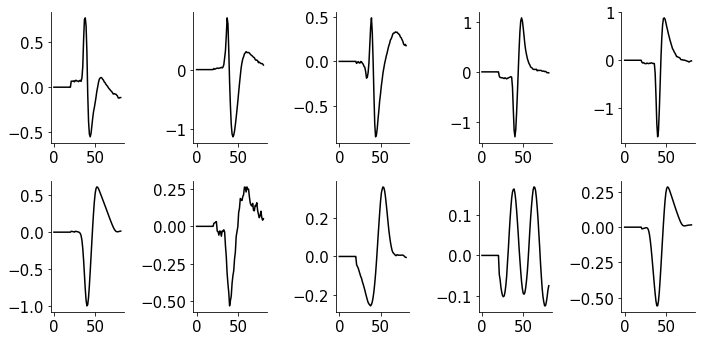

In [12]:
igood = np.random.randint(0,len(good_clu_ind),5)
inoise = np.random.randint(0,len(noise_clu_ind),5)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,5))
for i in range(len(igood)):
    ind_g = good_clu_ind[igood[i]]
    ind_n = noise_clu_ind[inoise[i]]
    plot_waveform(ind_g, clusterWaveforms, clusterQuality, ax[0,i])
    plot_waveform(ind_n, clusterWaveforms, clusterQuality, ax[1,i])

## RFC based model

In [13]:
n_depth = 80
n_estimators = 50
randomState = 10

In [14]:
rfcmodel = RandomForestClassifier(n_estimators, max_depth=n_depth, 
                                       random_state=randomState, bootstrap = False, 
                                       warm_start=True)
rfcmodel.n_estimators = n_estimators
history_rfc = rfcmodel.fit(X_train, y_train)
with open('rfcmodel.pkl', 'wb') as f:
    pickle.dump(rfcmodel, f)

In [15]:
# make predictions for test data
y_pred_rfc = rfcmodel.predict(X_test)

In [16]:
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred_rfc)
print("#### ACCURACY: %.2f%%" % (accuracy * 100.0))
precision = precision_score(y_test, y_pred_rfc, average='binary')
recall = recall_score(y_test, y_pred_rfc, average='binary')
print('Precision: {0:.2f}%'.format(precision*100))
print('Recall: {0:.2f}%'.format(recall*100))
print("\n\n")
print("#### Classification Report")
print(classification_report(y_test, y_pred_rfc))

#### ACCURACY: 88.61%
Precision: 89.31%
Recall: 91.40%



#### Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1591
           1       0.89      0.91      0.90      2221

    accuracy                           0.89      3812
   macro avg       0.88      0.88      0.88      3812
weighted avg       0.89      0.89      0.89      3812



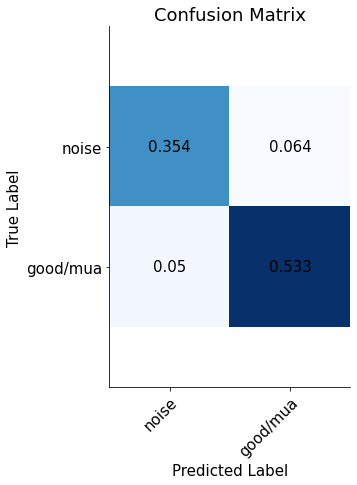

In [17]:
confmat = create_confusion_matrix(y_pred_rfc, y_test, 'RFC')

## Visualize the predictions results

**True positives**

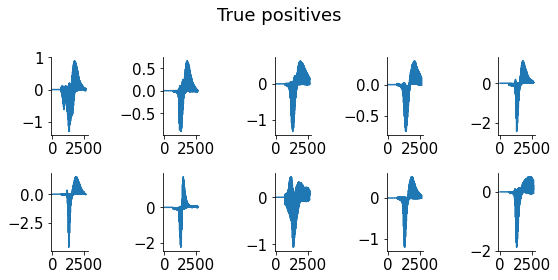

In [18]:
# randomly plot the good cells that are predicted correctly 
predict_idx = np.where(np.logical_and((y_test==1),(y_test==y_pred_rfc)))[0]
plot_idx = np.random.choice(predict_idx,10)
plt.figure(figsize=(8,4))
for i, idx in enumerate(plot_idx):
    plt.subplot(2,5,i+1)
    plt.plot(X_test[idx])
plt.suptitle('True positives')
plt.tight_layout()

**False Negatives**

191


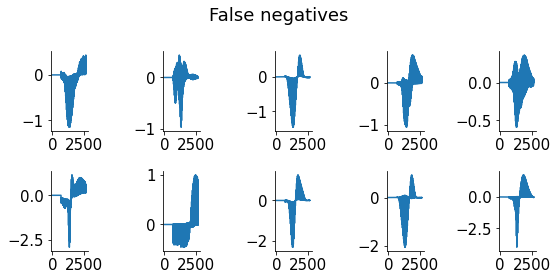

In [19]:
# randomly plot the good cells that are predicted incorrectly 
predict_idx = np.where(np.logical_and((y_test==1),(y_test!=y_pred_rfc)))[0]
print(len(predict_idx))
plot_idx = np.random.choice(predict_idx,10)
plt.figure(figsize=(8,4))
for i, idx in enumerate(plot_idx):
    plt.subplot(2,5,i+1)
    plt.plot(X_test[idx])
plt.suptitle('False negatives')
plt.tight_layout()

**True negatives**

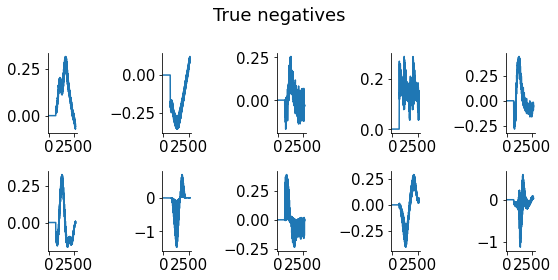

In [20]:
# randomly plot the noise cells that are predicted correctly 
predict_idx = np.where(np.logical_and((y_test==0),(y_test==y_pred_rfc)))[0]
plot_idx = np.random.choice(predict_idx,10)
plt.figure(figsize=(8,4))
for i, idx in enumerate(plot_idx):
    plt.subplot(2,5,i+1)
    plt.plot(X_test[idx])
plt.suptitle('True negatives')
plt.tight_layout()

**False positives**

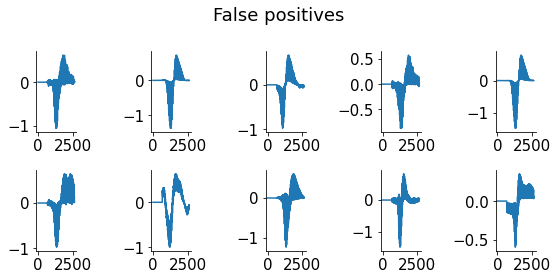

In [21]:
# randomly plot the noise cells that are predicted incorrectly 
predict_idx = np.where(np.logical_and((y_test==0),(y_test!=y_pred_rfc)))[0]
plot_idx = np.random.choice(predict_idx,10)
plt.figure(figsize=(8,4))
for i, idx in enumerate(plot_idx):
    plt.subplot(2,5,i+1)
    plt.plot(X_test[idx])
plt.suptitle('False positives')
plt.tight_layout()